# 7 Applications to neuroscience

In [1]:
from pathlib import Path

import numpy as np
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
from scipy import io as sio
import pygsp as pg
import IPython.display as ipd

## 7.1 Brain data

The data is one subject from the [human connectome project dataset](https://db.humanconnectome.org/).
There are both a graph and graph signals:
* `SC.mat`: brain structural connectivity matrix obtained from MRI diffusion imaging (our graph),
* `RS_TCs.mat`: functional signals obtained from resting-state fMRI (our graph signals),
* `Glasser360_2mm_codebook.mat`: 3D positions of the nodes in MNI coordinates (to layout the graph).

For both modalities, the brain atlas from Glasser et al (Nature 2016) is used, parcellating the brain into 360 regions.

In [2]:
datadir = Path('../data')

### 7.1.1 Structural connectivity graph

Load the connectivity matrix.

In [3]:
connectivity = sio.loadmat(datadir / 'SC.mat')['SC']
n_regions, n_regions = connectivity.shape
print(f'{n_regions} brain regions')

360 brain regions


Look at the structure of the connectivity matrix. Can you identify regions / communities?

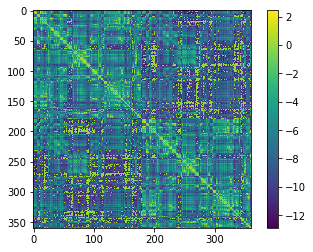

In [4]:
#plt.spy(connectivity);
plt.imshow(np.log(connectivity, out=np.zeros_like(connectivity), where=(connectivity!=0)));
plt.colorbar();

Look at the distribution of connection weights.

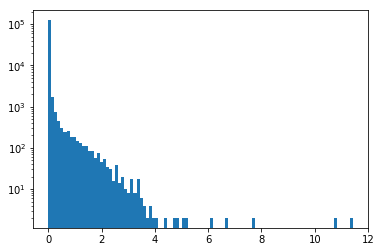

In [5]:
plt.hist(connectivity.flatten(), bins=100, log=True);

Build a PyGSP graph from the connectivity matrix. Use the normalized Laplacian.

In [6]:
graph = pg.graphs.Graph(connectivity, gtype='human connectome', lap_type='normalized')

print(f'{graph.N:_} nodes')
print(f'{graph.Ne:_} edges')
print(f'connected: {graph.is_connected()}')
print(f'directed: {graph.is_directed()}')

360 nodes
59_659 edges
connected: True
directed: False


Look at the degree distribution.

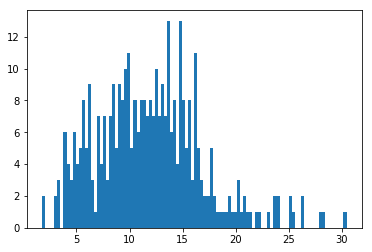

In [7]:
plt.hist(graph.dw, bins=100);

Look at the eigenvalues. If the graph is correct, you should find back the figure Giulia presented.

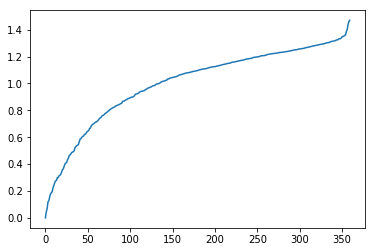

In [8]:
graph.compute_fourier_basis()
plt.plot(graph.e);

Look at the graph, with a force-directed layout.

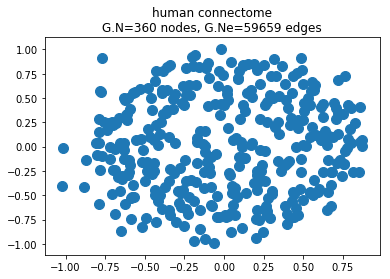

In [9]:
graph.set_coordinates(kind='spring')
graph.plot()

Now embed the graph in 3D using the real positions of the regions. Look at it again.

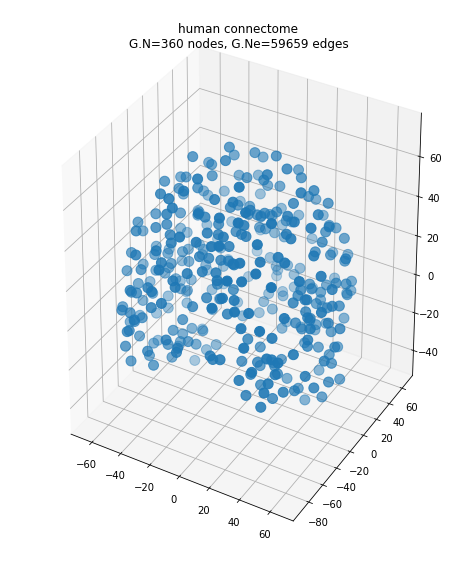

In [10]:
coordinates = sio.loadmat(datadir / 'Glasser360_2mm_codebook.mat')['codeBook']
graph.coords = np.stack([coordinates[0, 0][-2][0][region][:, 0] for region in range(n_regions)])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
graph.plot(ax=ax)
ax.set_aspect('equal', adjustable='box')

Plot some of the first eigenvectors of the normalized Laplacian, on the 3D embedded graph. Can you identify how the brain is splitted?

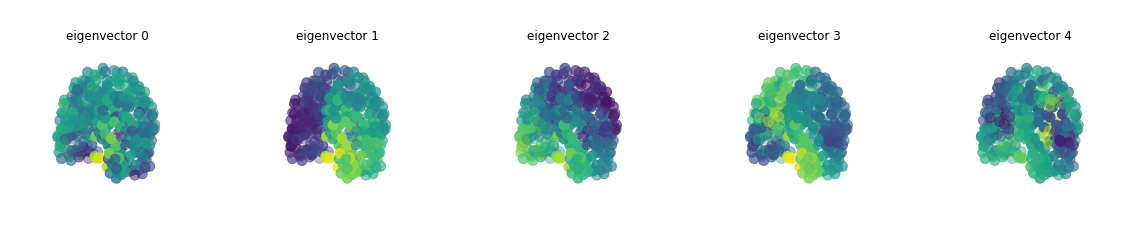

In [11]:
n_eigenvectors = 5

fig = plt.figure(figsize=(20, 5))
for i in range(n_eigenvectors):
    ax = fig.add_subplot(1, n_eigenvectors, i+1, projection='3d')
    ax.set_aspect('equal', adjustable='box')
    graph.plot_signal(graph.U[:, i], ax=ax, colorbar=False)
    ax.set_title(f'eigenvector {i}')
    ax.axis('off')

Project the graph in 2D, by ignoring the z coordinate. Plot again some eigenvectors.

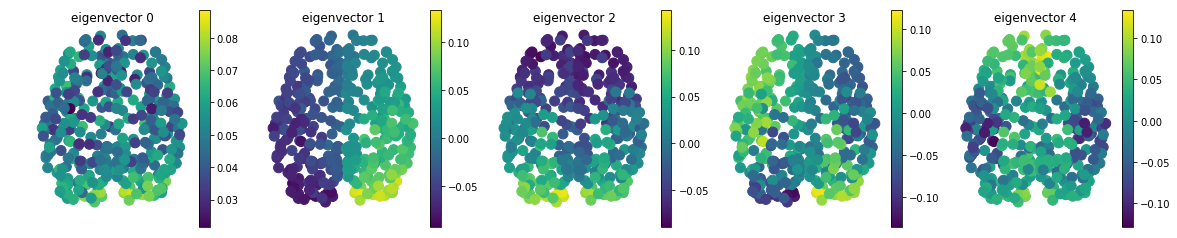

In [12]:
graph.coords = graph.coords[:, :2]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    graph.plot_signal(graph.U[:, i], ax=ax, colorbar=True)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'eigenvector {i}')
    ax.axis('off')

### 7.1.2 Functional activity (fMRI)

Load the fMRI signals.

In [13]:
signals = sio.loadmat(datadir / 'RS_TCs.mat')['RS_TCs']
assert signals.shape[0] == n_regions

See how the signals are correlated across regions.

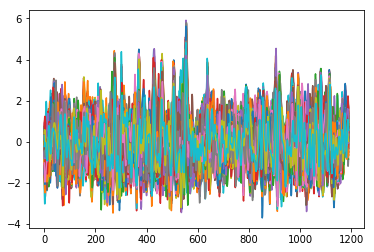

In [14]:
plt.plot(signals.T);

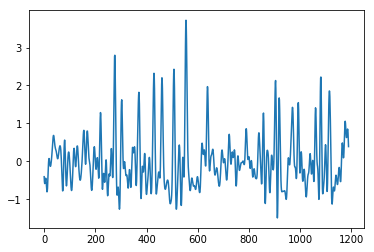

In [15]:
plt.plot(signals.mean(axis=0));

Look at some time slices of the fMRI signal on the functional connectivity graph.

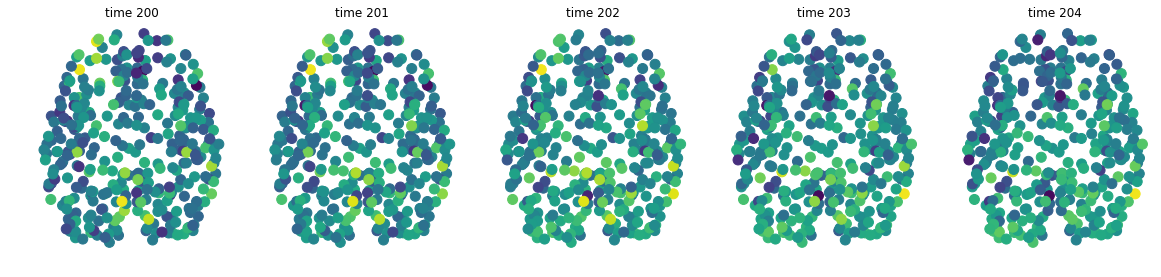

In [16]:
START = 200
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, ax in enumerate(axes):
    graph.plot_signal(signals[:, START+i], ax=ax, colorbar=False)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'time {START+i}')
    ax.axis('off')

Let's animate the functional activity on the structural graph.

In [17]:
plt.rc('animation', embed_limit=100)
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal', adjustable='box')
ax.axis('off')
plt.close(fig)
sc = ax.scatter(graph.coords[:, 0], graph.coords[:, 1])
cmap = plt.cm.get_cmap()

def animate(i):
    sc.set_color(cmap(signals[:, i]))
    ax.set_title(f'time {i}')
    return (sc,)

animation = mpl.animation.FuncAnimation(fig, animate, blit=True,
                                        frames=signals.shape[1], interval=20)

#ipd.HTML(animation.to_jshtml())

Is the functional signal smooth on the structural graph? Does the smoothness (measured with the Dirichlet form) vary across time?

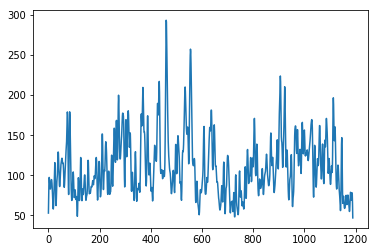

In [18]:
smoothness = signals.T @ graph.L @ signals
plt.plot(np.diag(smoothness));

## 7.1 Analysis of fMRI signals on the brain connectome

In this exercise, you will:
1. look at the spectral content (w.r.t. the connectome) of functional signals,
1. decompose that signal in an aligned (low frequencies) and liberal (high frequencies) component,
1. identify which brain regions mostly support aligned and liberal activities. The norms of these reconstructed portions of the signal are considered as measures of alignment/liberality of the functional signal to the structure.

All the details and justifications are in the paper [Functional Alignment with Anatomical Networks is Associated with Cognitive Flexibility](https://arxiv.org/abs/1611.08751).

In [19]:
# Number of eigenvalues to select for low frequencies (aligned functional activity).
THRESHOLD = 30 

graph.compute_fourier_basis()

Look at the norm (across time) of the spectral content of the fMRI signal.

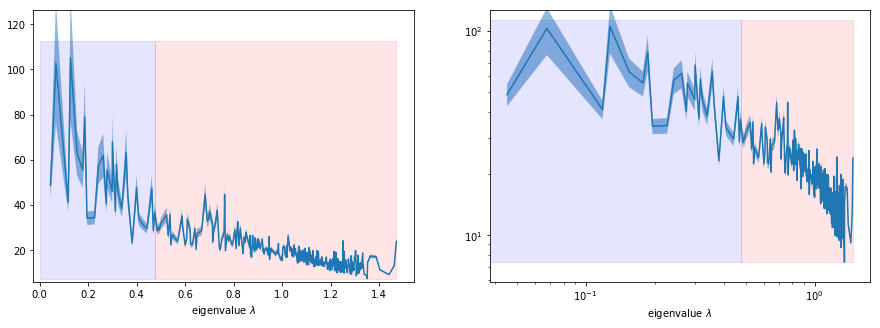

In [20]:
signals_fourier = graph.gft(signals)

#mean = np.mean(np.abs(signals_fourier), axis=1)
norm = np.linalg.norm(signals_fourier, axis=1)
var = np.var(signals_fourier, axis=1)

# Remove DC value (constant signal).
norm = norm[1:]
var = var[1:]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(graph.e[1:], norm)
axes[1].loglog(graph.e[1:], norm)

for ax in axes:
    ax.fill_between(graph.e[1:], norm-3*var, norm+3*var, alpha=0.5)
#    ax.vlines(graph.e[THRESHOLD], norm.min(), norm.max())
    ax.add_patch(mpl.patches.Rectangle((0, norm.min()), graph.e[THRESHOLD], norm.max(), color='b', alpha=0.1))
    ax.add_patch(mpl.patches.Rectangle((graph.e[THRESHOLD], norm.min()), graph.e[-1]-graph.e[THRESHOLD], norm.max(), color='r', alpha=0.1))
    ax.set_ylim(0.8*norm.min(), 1.2*norm.max());
    ax.set_xlabel(r'eigenvalue $\lambda$')

Design a complementary pair of ideal low-pass and high-pass filters with a cutoff set at the eigenvalue `graph.e[THRESHOLD]`.

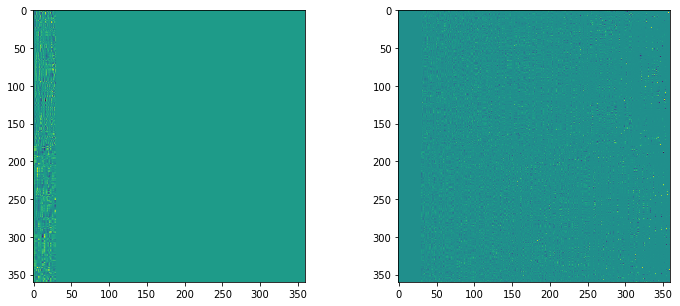

In [21]:
U_low = np.zeros_like(graph.U)
U_high = np.zeros_like(graph.U)

U_low[:, :THRESHOLD] = graph.U[:, :THRESHOLD]
U_high[:, THRESHOLD:] = graph.U[:, THRESHOLD:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(U_low)
ax2.imshow(U_high);

Decompose the fMRI signal in an aligned component (which corresponds to low frequencies) and a liberal component (which corresponds to high frequencies).

In [22]:
signals_aligned = U_low @ U_low.T @ signals
signals_liberal = U_high @ U_high.T @ signals

If the graph Fourier transform has already been computed, then below is a more efficient way to compute it.

In [23]:
signals_aligned = graph.igft(signals_fourier[:, :THRESHOLD])
signals_liberal = graph.igft(signals_fourier[:, THRESHOLD:])

An even better way is to use graph filters. If you can tolerate approximations in filtering, you can even avoid to compute the eigendecomposition of the Laplacian by approximating the filters by Chebyshev polynomials.

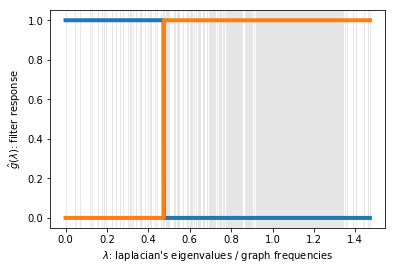

In [24]:
def g_low(eigenvalue):
    return eigenvalue < graph.e[THRESHOLD]

def g_high(eigenvalue):
    return eigenvalue >= graph.e[THRESHOLD]

g = pg.filters.Filter(graph, [g_low, g_high])
g.plot(show_sum=False)

signals_filtered = g.filter(signals, method='exact')
signals_aligned = signals_filtered[..., 0]
signals_liberal = signals_filtered[..., 1]

Plot the original functional signal along with its aligned and liberal decomposition. Plot as an image whose rows correspond to brain regions and columns to time.

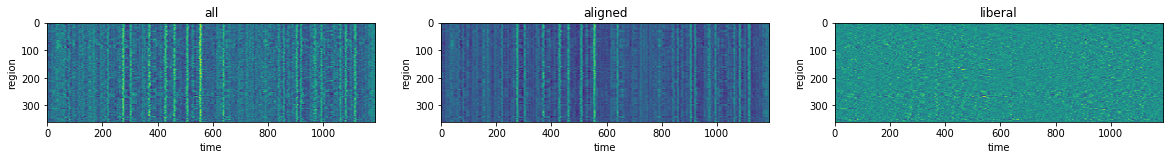

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
axes[0].imshow(signals)
axes[1].imshow(signals_aligned)
axes[2].imshow(signals_liberal)
axes[0].set_title('all')
axes[1].set_title('aligned')
axes[2].set_title('liberal')
for ax in axes:
    ax.set_xlabel('time')
    ax.set_ylabel('region')

Compute the norm (across time) of the aligned and liberal components. Plot those two norms as graph signals.

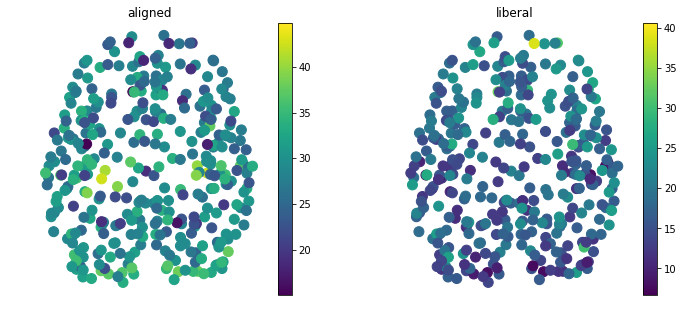

In [26]:
norm_aligned = np.linalg.norm(signals_aligned, axis=1)
norm_liberal = np.linalg.norm(signals_liberal, axis=1)
var_aligned = np.var(signals_aligned, axis=1)
var_liberal = np.var(signals_liberal, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
graph.plot_signal(norm_aligned, ax=ax1)
graph.plot_signal(norm_liberal, ax=ax2)
ax1.set_title('aligned')
ax2.set_title('liberal')
ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')
ax1.axis('off')
ax2.axis('off');

Can you identify the brain regions that correpond to activity aligned with the underlying structural graph from the regions that correspond to liberal activity? If you could reproduce the findings of the paper, sensory regions (visual, somatomotor, auditory) should correspond to aligned activity, and high-level cognition (multisensory integration, memory, decision making) should correpond to liberal activity.

## 7.2 Assessment of significant excursions in fMRI signals

In this exercise, you will:
1. generate surrogate signals (which have the same frequency content as the real signals) by randomizing the Fourier coefficients,
1. test for significant excursions in empirical data against those surrogates.

The method has been introduced in [A Spectral Method for Generating Surrogate Graph Signals](http://miplab.epfl.ch/pub/pirondini1601.pdf). A more general picture is drawn in [A Graph Signal Processing Perspective on Functional Brain Imaging](https://miplab.epfl.ch/pub/huang1801.pdf).

In [27]:
N_SURROGATES = 19
print(f'p-value = {1/(N_SURROGATES+1)}')

p-value = 0.05


1. Compute the spectrum of the fMRI signal.
1. Randomly flip the sign of the Fourier coefficients. Generate one permutation vector per surrogate. Be sure to use the same permutation across time to preserve temporal properties.
1. Compute the inverse Fourier transform for each surrogate.

In [28]:
signals_fourier = graph.gft(signals)

sign = np.random.randint(0, 2, size=(n_regions, N_SURROGATES))
sign[sign==0] = -1
signals_random = sign[:, np.newaxis, :] * signals_fourier[:, :, np.newaxis]

surrogates = graph.igft(signals_random)

Verify that the surrogates do indeed have the same power spectral density (PSD).

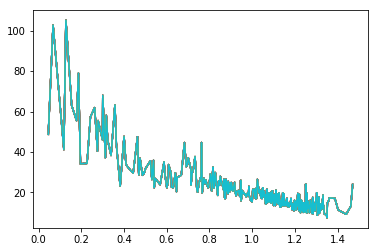

In [29]:
plt.plot(graph.e[1:], np.linalg.norm(graph.gft(signals)[1:], axis=1))

for surrogate in surrogates.T:
    plt.plot(graph.e[1:], np.linalg.norm(graph.gft(surrogate.T)[1:], axis=1))

Plot the time course of some surrogates. Again, plot as an image whose rows correspond to brain regions and columns to time.

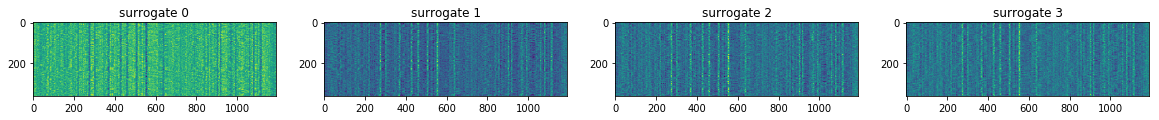

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(surrogates[..., i])
    ax.set_title(f'surrogate {i}')

Test for significant excursions in empirical data against surrogate signals.

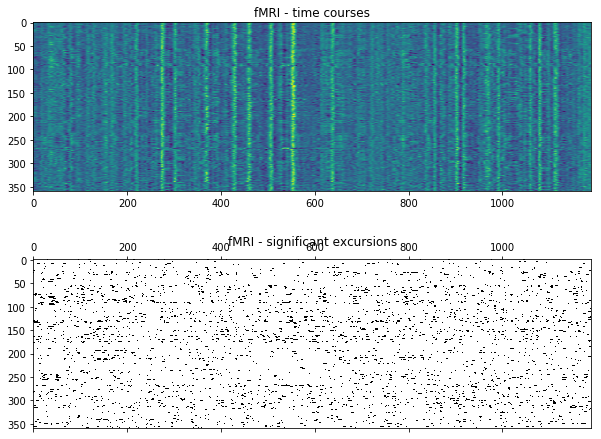

In [31]:
# Take maximum across surrogates: 1/(19+1) = 0.05 p-value (non corrected) for 19 surrogates.
# Different thr for different timepoints and nodes.
threshold = np.max(np.abs(surrogates), axis=2)
excursions = np.abs(signals) > threshold

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].imshow(signals)
axes[1].spy(excursions)
axes[0].set_title('fMRI - time courses')
axes[1].set_title('fMRI - significant excursions');

Which brain regions get wild (or tame)?

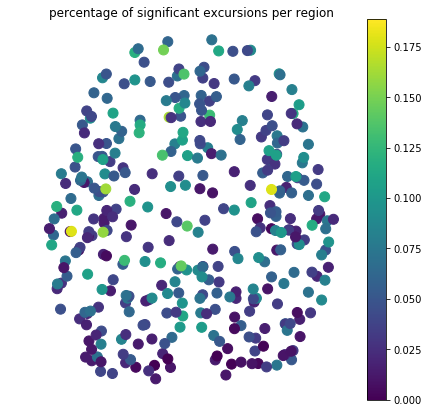

In [32]:
percentage = excursions.sum(1) / signals.shape[1]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
graph.plot_signal(percentage, ax=ax)
ax.set_title('percentage of significant excursions per region')
ax.set_aspect('equal', adjustable='box')
ax.axis('off');